In [1]:
!pip install kagglehub

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Path to dataset files: /kaggle/input/microsoft-catsvsdogs-dataset


In [2]:
DATA_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset'

In [4]:
from tqdm import tqdm
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import VGG16,preprocess_input
import numpy as np
import os


In [5]:
from re import VERBOSE
#Loading VGGI model without top layers

feature_extractor = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(224,224,3))

def extract_features(data_dir,target_size=(224,224),batch_size=32):
    X,y = [],[]
    # Construct the path to the 'PetImages' directory
    pet_images_dir = os.path.join(data_dir, 'PetImages')
    # Populate classes with directory names by filtering out non-directories within 'PetImages'
    classes = [d for d in os.listdir(pet_images_dir) if os.path.isdir(os.path.join(pet_images_dir, d))]
    for label in classes:
      folder = os.path.join(pet_images_dir,label) # Join with pet_images_dir
      files = os.listdir(folder)
      #preprocessing in batches
      for i in tqdm(range(0,len(files),batch_size),desc=f'Processing {label}'):
        batch_files = files[i:i+batch_size]
        batch_images = []
        valid_labels =[]
        for f_name in batch_files:
          try:
            path = os.path.join(folder,f_name)
            img = load_img(path,target_size=target_size)
            img_array = img_to_array(img)
            batch_images.append(img_array)
            valid_labels.append(label)
          except:
            continue

        if batch_images:
          batch_images = np.array(batch_images)
          batch_images = preprocess_input(batch_images)
          #Extracting features for the whole batch
          features = feature_extractor.predict(batch_images,verbose=0)
          X.extend(features)
          y.extend(valid_labels)
    return np.array(X),np.array(y)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
#Running the execution
X,y = extract_features(DATA_DIR,target_size=(224,224),batch_size=32)
print("Feature Matrix: ",X.shape,"Label Vector: ",y.shape)

Processing Dog:  10%|▉         | 38/391 [00:34<03:20,  1.76it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Processing Cat: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]

Feature Matrix:  (24998, 512) Label Vector:  (24998,)


In [7]:
#Training, testing and splitting the dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
le = LabelEncoder()
y = le.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [8]:
#Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#Finding balanced data
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(le.inverse_transform(unique), counts)))


{np.str_('Cat'): np.int64(10014), np.str_('Dog'): np.int64(9984)}


In [10]:
#Training the model
from sklearn.svm import SVC

sv = SVC(C=1.0,kernel='rbf',probability=True,class_weight='balanced',random_state=42)
sv.fit(X_train_scaled,y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [11]:
#Model Evalution
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score

y_pred = sv.predict(X_test_scaled)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred,target_names=le.classes_))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
score = sv.decision_function(X_test_scaled)
print("ROC_AUC Score:",roc_auc_score(y_test,score))

Accuracy:  0.9822
Classification Report: 
               precision    recall  f1-score   support

         Cat       0.98      0.99      0.98      2485
         Dog       0.99      0.98      0.98      2515

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Confusion Matrix: 
 [[2449   36]
 [  53 2462]]
ROC_AUC Score: 0.9978279218051849


In [12]:
#Saving the model
import joblib
artifacts = {'svm':sv,'label_encoder':le,'scaler':scaler}
joblib.dump(artifacts,'cats_vs_dogs.joblib')
print("Model Saved as cats_vs_dogs.joblib ")

Model Saved as cats_vs_dogs.joblib 


In [17]:
#Testing
test_img_path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1234.jpg'
img = load_img(test_img_path,target_size=(224,224))
arr = img_to_array(img)
arr = np.expand_dims(arr,axis=0)
arr = preprocess_input(arr)
features = feature_extractor.predict(arr)
features_scaled = scaler.transform(features) #.reshape(1,-1)
prediction = sv.predict(features_scaled)
label = le.inverse_transform(prediction)[0]
print("Predicted Label: ",label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Label:  Dog


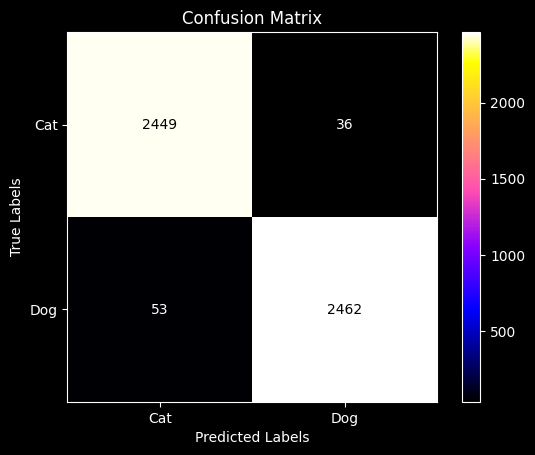

In [19]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot(cmap='gnuplot2')
plt.style.use('dark_background')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
#

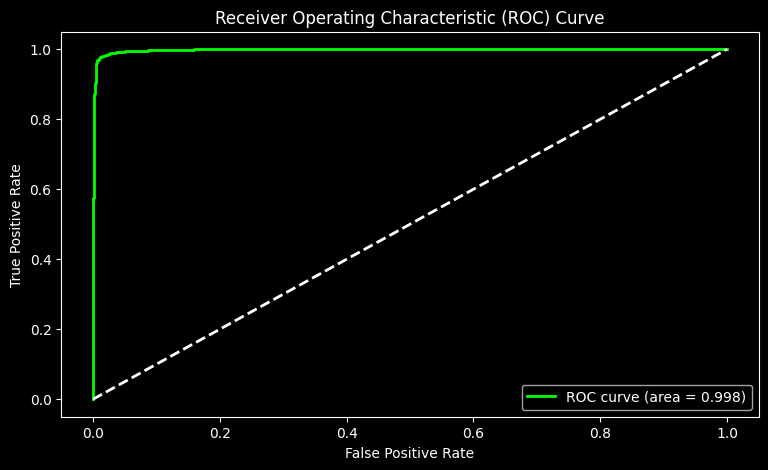

In [22]:
#ROC curve
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()
y_score = sv.decision_function(X_test_scaled)

if len(np.unique(y_test_bin)) == 2:
  fpr,tpr,thresholds = roc_curve(y_test_bin,y_score)
  roc_auc = auc(fpr,tpr)
  plt.figure(figsize=(9,5))
  plt.plot(fpr,tpr,color='lime',lw=2,label=f'ROC curve (area = {roc_auc:.3f})')
  plt.plot([0,1],[0,1],color='white',lw=2,linestyle='--')
  # plt.xlim([0.0,1.0])
  # plt.ylim([0.0,1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()
else:
  print("ROC curve can't be ploted")